In [ ]:
import os
os.chdir(os.path.dirname("../"))

In [2]:
import deepof.data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact

In [3]:
%%time
deepof_main = deepof.data.project(path=os.path.join("..","..","Desktop","deepof-data"),  #Path where to find the required files
                                  smooth_alpha=0.99,                                     #Alpha value for exponentially weighted smoothing
                                  arena_dims=[380])

CPU times: user 14.8 s, sys: 2.65 s, total: 17.4 s
Wall time: 4.04 s


# Run project

In [4]:
%%time
deepof_main = deepof_main.run(verbose=True)
print(deepof_main)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
deepof analysis of 109 videos
CPU times: user 25.8 s, sys: 2.06 s, total: 27.8 s
Wall time: 28.4 s


# Check tagging quality

In [5]:
all_quality = pd.concat([tab for tab in deepof_main.get_quality().values()]).droplevel("scorer", axis=1)

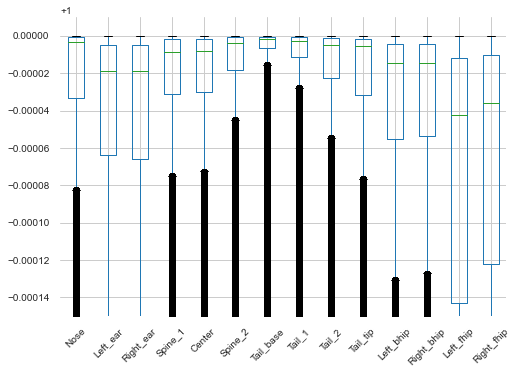

In [6]:
all_quality.boxplot(rot=45)
plt.ylim(0.99985, 1.00001)
plt.show()

In [7]:
@interact(quality_top=(0., 1., 0.01))
def low_quality_tags(quality_top):
    pd.DataFrame(pd.melt(all_quality).groupby("bodyparts").value.apply(
        lambda y: sum(y<quality_top) / len(y) * 100)
                ).sort_values(by="value", ascending=False).plot.bar(rot=45)
    
    plt.xlabel("body part")
    plt.ylabel("Tags with quality under {} (%)".format(quality_top))
    plt.tight_layout()
    plt.legend([])
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='quality_top', max=1.0, step=0.01), Output()), _dom_c…

# Generate coords

In [8]:
%%time
deepof_coords = deepof_main.get_coords(center="Center", polar=False, speed=0, align="Spine_1")

CPU times: user 36.7 s, sys: 187 ms, total: 36.8 s
Wall time: 36.8 s


# Visualization playground

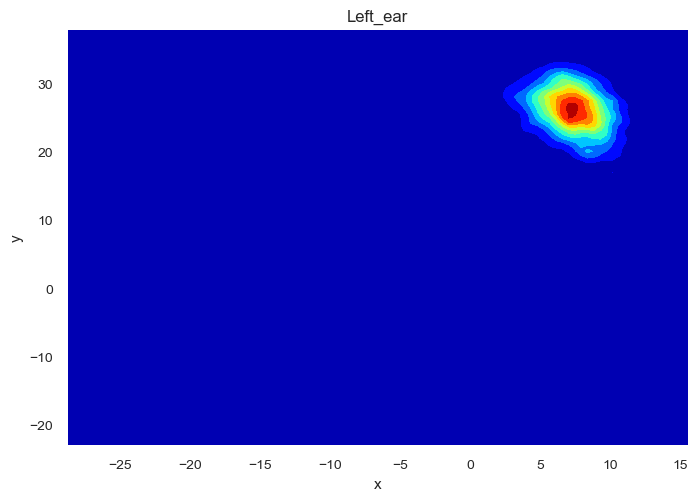

In [13]:
heat = deepof_coords.plot_heatmaps(['Left_ear'], i=0, dpi=100)

# Dimensionality reduction playground

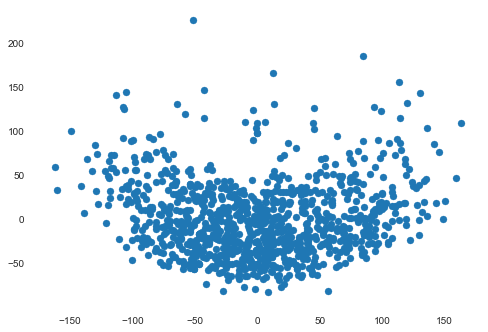

In [15]:
pca = deepof_coords.pca(2, 1000)
plt.scatter(pca[0][:,0],pca[0][:,1])
plt.show()

# Preprocessing playground

In [ ]:
mtest = merge_tables(
                      DLC_social_1_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose')
                      #DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [ ]:
mtest2 = merge_tables(
                      DLC_social_2_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose'),
                      #DLC_social_2_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [ ]:
%%time
pttest = mtest.preprocess(window_size=13, window_step=10, filter=None, sigma=55,
                          shift=0, scale='standard', align='center', shuffle=True, test_videos=0)
print(pttest.shape)
#print(pttrain.shape)

In [ ]:
%%time
pttest2 = mtest2.preprocess(window_size=13, window_step=1, filter=None, sigma=55,
                            shift=0, scale="standard", align='all', shuffle=False)
pttest2.shape

In [ ]:
n = 100

plt.scatter(pttest[:n,10,0], pttest[:n,10,1], label='Nose')
plt.scatter(pttest[:n,10,2], pttest[:n,10,3], label='Right ear')
plt.scatter(pttest[:n,10,4], pttest[:n,10,5], label='Right hips')
plt.scatter(pttest[:n,10,6], pttest[:n,10,7], label='Left ear')
plt.scatter(pttest[:n,10,8], pttest[:n,10,9], label='Left hips')
plt.scatter(pttest[:n,10,10], pttest[:n,10,11], label='Tail base')


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [ ]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [ ]:
NAME = 'Baseline_AE_512_wu10_slide10_gauss_fullval'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

In [ ]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [ ]:
ae.summary()

In [ ]:
%%time

tf.keras.backend.clear_session()

encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(pttest.shape,
                                                                               loss='ELBO',
                                                                               number_of_components=30,
                                                                               kl_warmup_epochs=10,
                                                                               mmd_warmup_epochs=10,
                                                                               encoding=16,
                                                                               predictor=False).build()
# gmvaep.build(pttest.shape)

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
batch_size = 512
rates, losses = find_learning_rate(gmvaep, pttest[:512*10], pttest[:512*10], epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.title("Learning rate tuning")
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])
plt.show()

# Encoding plots

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import plotly.express as px

In [ ]:
data = pttest
samples = 15000
montecarlo = 10

In [ ]:
weights = "GMVAE_components=30_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200804-225526_final_weights.h5"

gmvaep.load_weights(weights)

if montecarlo:
    clusts = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
    clusters = clusts.mean(axis=0)
    clusters = np.argmax(clusters, axis=1)
    
else:
    clusters = grouper(data[:samples], training=False)

    
    clusters = np.argmax(clusters, axis=1)

In [ ]:
def plot_encodings(data, samples, n, clusters, threshold):
    
    reducer  = PCA(n_components=n)
    clusters = clusters[:, :samples]
    filter   = np.max(np.mean(clusters, axis=0), axis=1) > threshold
    encoder.predict(data[:samples][filter])
    print("{}/{} samples used ({}%); confidence threshold={}".format(sum(filter),
                                                                     samples,
                                                                     sum(filter)/samples*100,
                                                                     threshold))
    
    clusters = np.argmax(np.mean(clusters, axis=0), axis=1)[filter]
    rep = reducer.fit_transform(encoder.predict(data[:samples][filter]))

    if n == 2:
        df = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter(data_frame=df, x="encoding-1", y="encoding-2",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)


    elif n == 3:
        df3d = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"encoding-3":rep[:,2],
                         "clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter_3d(data_frame=df3d, x="encoding-1", y="encoding-2", z="encoding-3",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)

    return enc

plot_encodings(data, 5000, 2, clusts, 0.5)

# Confidence per cluster

In [ ]:
from collections import Counter
Counter(clusters)

In [ ]:
# Confidence distribution per cluster
for cl in range(5):
    cl_select = np.argmax(np.mean(clusts, axis=0), axis=1) == cl
    dt = np.mean(clusts[:,cl_select,cl], axis=0)
    sns.kdeplot(dt, shade=True, label=cl)
    
plt.xlabel('MC Dropout confidence')
plt.ylabel('Density')

plt.show()

In [ ]:
def animated_cluster_heatmap(data, clust, clusters, threshold=0.75, samples=False):
    
    if not samples:
        samples = data.shape[0]
    tpoints = data.shape[1]
    bdparts = data.shape[2] // 2
    
    cls = clusters[:,:samples,:]
    filt = np.max(np.mean(cls, axis=0), axis=1) > threshold
    
    cls = np.argmax(np.mean(cls, axis=0), axis=1)[filt]
    clust_series = data[:samples][filt][cls==clust]
        
    rshape = clust_series.reshape(clust_series.shape[0]*clust_series.shape[1],
                                  clust_series.shape[2])
    
    cluster_df = pd.DataFrame()
    cluster_df['x'] = rshape[:,[0,2,4,6,8,10]].flatten(order='F')
    cluster_df['y'] = rshape[:,[1,3,5,7,9,11]].flatten(order='F')
    cluster_df['bpart'] = np.tile(np.repeat(np.arange(bdparts),
                                            clust_series.shape[0]), tpoints)
    cluster_df['frame'] = np.tile(np.repeat(np.arange(tpoints),
                                            clust_series.shape[0]), bdparts)
        
    fig = px.density_contour(data_frame=cluster_df, x='x', y='y', animation_frame='frame',
                     width=600, height=600, 
                     color='bpart',color_discrete_sequence=px.colors.qualitative.T10)

    fig.update_traces(contours_coloring="fill", 
                      contours_showlabels = True)
    
    fig.update_xaxes(range=[-3, 3])
    fig.update_yaxes(range=[-3, 3])

    return fig

In [ ]:
# animated_cluster_heatmap(pttest, 4, clusts, samples=10)

# Stability across runs

In [ ]:
weights = [i for i in os.listdir() if "GMVAE" in i and ".h5" in i]
mult_clusters = np.zeros([len(weights), samples])
mean_conf = []

for k,i in tqdm(enumerate(sorted(weights))):
    print(i)
    gmvaep.load_weights(i)

    if montecarlo:
        clusters = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
        clusters = clusters.mean(axis=0)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    
    else:
        clusters = grouper(data[:samples], training=False)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    mult_clusters[k] = clusters

In [ ]:
clusts.shape

In [ ]:
import pandas as pd
from itertools import combinations
from sklearn.metrics import adjusted_rand_score

In [ ]:
mult_clusters

In [ ]:
thr = 0.95
ari_dist = []

for i,k in enumerate(combinations(range(len(weights)),2)):
    filt = ((mean_conf[k[0]] > thr) & (mean_conf[k[1]]>thr))
    
    ari = adjusted_rand_score(mult_clusters[k[0]][filt],
                              mult_clusters[k[1]][filt])
    
    ari_dist.append(ari)

In [ ]:
ari_dist

In [ ]:
random_ari = []
for i in tqdm(range(6)):
    random_ari.append(adjusted_rand_score(np.random.uniform(0,6,50).astype(int),
                                          np.random.uniform(0,6,50).astype(int)))

In [ ]:
sns.kdeplot(ari_dist, label="ARI gmvaep", shade=True)
sns.kdeplot(random_ari, label="ARI random", shade=True)

plt.xlabel("Normalised Adjusted Rand Index")
plt.ylabel("Density")

plt.legend()
plt.show()

# Cluster differences across conditions

In [ ]:
%%time

DLCS1_coords = DLC_social_1_coords.get_coords(center="B_Center",polar=False, length='00:10:00', align='B_Nose')

Treatment_coords = {}

for cond in Treatment_dict.keys():
    Treatment_coords[cond] = DLCS1_coords.filter(Treatment_dict[cond]).preprocess(window_size=13, 
                                                 window_step=10, filter=None, scale='standard', align='center')

In [ ]:
%%time

montecarlo = 10

Predictions_per_cond = {}
Confidences_per_cond = {}

for cond in Treatment_dict.keys():
    
    Predictions_per_cond[cond] = np.stack([grouper(Treatment_coords[cond]
                         ) for sample in (tqdm(range(montecarlo)))])

    Confidences_per_cond[cond] = np.mean(Predictions_per_cond[cond], axis=0)
    Predictions_per_cond[cond] = np.argmax(Confidences_per_cond[cond], axis=1) 
    


In [ ]:
Predictions_per_condition = {k:{cl:[] for cl in range(1,31)} for k in Treatment_dict.keys()}

for k in Predictions_per_cond.values():
    print(Counter(k))

In [ ]:
for cond in Treatment_dict.keys():
    start = 0
    for i,j in enumerate(DLCS1_coords.filter(Treatment_dict[cond]).values()):
        
        update  = start + j.shape[0]//10
        counter = Counter(Predictions_per_cond[cond][start:update])
        start  += j.shape[0]//10
        
        for num in counter.keys():
            Predictions_per_condition[cond][num+1].append(counter[num+1])

In [ ]:
counts = []
clusters = []
conditions = []
for cond,v in Predictions_per_condition.items():
    for cluster,i in v.items():
        counts+=i
        clusters+=list(np.repeat(cluster, len(i)))
        conditions+=list(np.repeat(cond, len(i)))
        
Prediction_per_cond_df = pd.DataFrame({'condition':conditions,
                                       'cluster':clusters,
                                       'count':counts})

In [ ]:
px.box(data_frame=Prediction_per_cond_df, x='cluster', y='count', color='condition')

# Others

In [ ]:
for i in range(5):
    print(Counter(labels[str(i)]))

In [ ]:
adjusted_rand_score(labels[0], labels[3])

In [ ]:
sns.distplot(ari_dist)
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Count")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from scipy.stats import entropy

In [ ]:
entropy(np.array([0.5,0,0.5,0]))

In [ ]:
tfd.Categorical(np.array([0.5,0.5,0.5,0.5])).entropy()

In [ ]:
pk = np.array([0.5,0,0.5,0])

In [ ]:
np.log(pk)

In [ ]:
np.clip(np.log(pk), 0, 1)

In [ ]:
-np.sum(pk*np.array([-0.69314718,        0, -0.69314718,        0]))

In [ ]:
import tensorflow.keras.backend as K
entropy = K.sum(tf.multiply(pk, tf.where(~tf.math.is_inf(K.log(pk)), K.log(pk), 0)), axis=0)
entropy

In [ ]:
sns.distplot(np.max(clusts, axis=1))
sns.distplot(clusts.reshape(clusts.shape[0] * clusts.shape[1]))
plt.axvline(1/10)
plt.show()

In [ ]:
gauss_means = gmvaep.get_layer(name="dense_4").get_weights()[0][:32]
gauss_variances = tf.keras.activations.softplus(gmvaep.get_layer(name="dense_4").get_weights()[0][32:]).numpy()

In [ ]:
gauss_means.shape == gauss_variances.shape

In [ ]:
k=10
n=100
samples = []
for i in range(k):
    samples.append(np.random.normal(gauss_means[:,i], gauss_variances[:,i], size=(100,32)))

In [ ]:
from scipy.stats import ttest_ind
test_matrix = np.zeros([k,k])
for i in range(k):
    for j in range(k):
        test_matrix[i][j] = np.mean(ttest_ind(samples[i], samples[j], equal_var=False)[1])

In [ ]:
threshold = 0.55
np.sum(test_matrix > threshold)

In [ ]:
# Transition matrix


In [ ]:
Treatment_dict

In [ ]:
# Anomaly detection - the model was trained in the WT - NS mice alone
gmvaep.load_weights("GMVAE_components=10_loss=ELBO_kl_warmup=20_mmd_warmup=5_20200721-043310_final_weights.h5")

In [ ]:
WT_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+NS']}, typ="coords")
WT_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+CSDS']}, typ="coords")
MU_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+NS']}, typ="coords")
MU_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+CSDS']}, typ="coords")

preps = [WT_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         WT_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True)]

In [ ]:
preds = [gmvaep.predict(i) for i in preps]

In [ ]:
from sklearn.metrics import mean_absolute_error
reconst_error = {k:mean_absolute_error(preps[i].reshape(preps[i].shape[0]*preps[i].shape[1],12).T, 
                                       preds[i].reshape(preds[i].shape[0]*preds[i].shape[1],12).T,
                                       multioutput='raw_values') for i,k in enumerate(Treatment_dict.keys())}

reconst_error

In [ ]:
reconst_df = pd.concat([pd.DataFrame(np.concatenate([np.repeat(k, len(v)).reshape(len(v),1), v.reshape(len(v),1)],axis=1)) for k,v in reconst_error.items()])
reconst_df = reconst_df.astype({0:str,1:float})

In [ ]:
sns.boxplot(data=reconst_df, x=0, y=1, orient='vertical')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,0.35)
plt.show()

In [ ]:
# Check frame rates